# Building a Generative Adversarial Network

In [ ]:
import torch
torch.manual_seed(42)
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm.notebook import tqdm
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision.utils import save_image

import os
os.environ["KAGGLE_CONFIG_DIR"] = "/content"

# Loading Dataset

In [ ]:
!kaggle datasets download -d spandan2/cats-faces-64x64-for-generative-models

 82% 79.0M/96.0M [00:00<00:00, 186MB/s]
100% 96.0M/96.0M [00:00<00:00, 191MB/s]


In [ ]:
!unzip \*.zip && rm \*.zip

Streaming output truncated to the last 5000 lines.
  inflating: cats/cats/55.jpg        
  inflating: cats/cats/550.jpg       
  inflating: cats/cats/5500.jpg      
  inflating: cats/cats/5501.jpg      
  inflating: cats/cats/5502.jpg      
  inflating: cats/cats/5503.jpg      
  inflating: cats/cats/5504.jpg      
  inflating: cats/cats/5505.jpg      
  inflating: cats/cats/5506.jpg      
  inflating: cats/cats/5507.jpg      
  inflating: cats/cats/5508.jpg      
  inflating: cats/cats/5509.jpg      
  inflating: cats/cats/551.jpg       
  inflating: cats/cats/5510.jpg      
  inflating: cats/cats/5511.jpg      
  inflating: cats/cats/5512.jpg      
  inflating: cats/cats/5513.jpg      
  inflating: cats/cats/5514.jpg      
  inflating: cats/cats/5515.jpg      
  inflating: cats/cats/5516.jpg      
  inflating: cats/cats/5517.jpg      
  inflating: cats/cats/5518.jpg      
  inflating: cats/cats/5519.jpg      
  inflating: cats/cats/552.jpg       
  inflating: cats/cats/5520.jpg      

# **Set Up Training Parameters and Load Data**

In [ ]:
batch_size = 10

# 64x64 images
transform = transforms.Compose([transforms.Resize(64),
                                transforms.CenterCrop(64),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_data = datasets.ImageFolder('/content/cats', transform=transform)
train_loader = torch.utils.data.DataLoader(train_data, shuffle=True,
                                           batch_size=batch_size)

imgs, label = next(iter(train_loader))
imgs = imgs.numpy().transpose(0, 2, 3, 1)

#**Generator**
#**Network: Generator**

#**Input: (batch_size, nz, 1, 1)**

      |
      V
#**ConvTranspose2d(in_channels=nz, out_channels=384, kernel_size=(4, 4), stride=1, padding=0)**
#**BatchNorm2d()**
#**LeakyReLU()**

      |
      V
#**ConvTranspose2d(in_channels=384, out_channels=192, kernel_size=(4, 4), stride=2, padding=1)**
#**BatchNorm2d()**
#**LeakyReLU()**

      |
      V
#**ConvTranspose2d(in_channels=192, out_channels=96, kernel_size=(4, 4), stride=2, padding=1)**
#**BatchNorm2d()**
#**LeakyReLU()**

      |
      V
#**ConvTranspose2d(in_channels=96, out_channels=48, kernel_size=(4, 4), stride=2, padding=1)**
#**BatchNorm2d()**
#**LeakyReLU()**

      |
      V
#**ConvTranspose2d(in_channels=48, out_channels=3, kernel_size=(4, 4), stride=2, padding=1)**
#**BatchNorm2d()**
#**LeakyReLU()**

#**Rationale:**
#**The generator uses layers that gradually make the random noise look like a real image, it uses batch normalization and Leaky ReLU to make training stable and add complexity, with larger filters and steps, it captures important features for realistic images,the last layer makes the final image, and the tanh function keeps pixel values in a certain range,the generator and discriminator have similar structures, balancing how they learn from each other**


In [ ]:
class Generator(nn.Module):
    def __init__(self, nz, nfeats, nchannels):
        super(Generator, self).__init__()

        # input is Z, going into a convolution
        self.conv1 = nn.ConvTranspose2d(nz, nfeats * 8, 4, 1, 0, bias=False)
        self.bn1 = nn.BatchNorm2d(nfeats * 8)
        # state size. (nfeats*8) x 4 x 4

        self.conv2 = nn.ConvTranspose2d(nfeats * 8, nfeats * 8, 4, 2, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(nfeats * 8)
        # state size. (nfeats*8) x 8 x 8

        self.conv3 = nn.ConvTranspose2d(nfeats * 8, nfeats * 4, 4, 2, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(nfeats * 4)
        # state size. (nfeats*4) x 16 x 16

        self.conv4 = nn.ConvTranspose2d(nfeats * 4, nfeats * 2, 4, 2, 1, bias=False)
        self.bn4 = nn.BatchNorm2d(nfeats * 2)
        # state size. (nfeats * 2) x 32 x 32

        self.conv5 = nn.ConvTranspose2d(nfeats * 2, nfeats, 4, 2, 1, bias=False)
        self.bn5 = nn.BatchNorm2d(nfeats)
        # state size. (nfeats) x 64 x 64

        self.conv6 = nn.ConvTranspose2d(nfeats, nchannels, 3, 1, 1, bias=False)

        # state size. (nchannels) x 64 x 64

    def forward(self, x):
        x = F.leaky_relu(self.bn1(self.conv1(x)))
        x = F.leaky_relu(self.bn2(self.conv2(x)))
        x = F.leaky_relu(self.bn3(self.conv3(x)))
        x = F.leaky_relu(self.bn4(self.conv4(x)))
        x = F.leaky_relu(self.bn5(self.conv5(x)))
        x = torch.tanh(self.conv6(x))

        return x

#**Discriminator**

#**Input: (batch_size, 3, 64, 64)**

      |
      V
#**Conv2d(in_channels=3, out_channels=48, kernel_size=(4, 4), stride=2, padding=1)**
#**BatchNorm2d()**
#**LeakyReLU()**

      |
      V
#**Conv2d(in_channels=48, out_channels=96, kernel_size=(4, 4), stride=2, padding=1)**
#**BatchNorm2d()**
#**LeakyReLU()**

      |
      V
#**Conv2d(in_channels=96, out_channels=192, kernel_size=(4, 4), stride=2, padding=1)**
#**BatchNorm2d()**
#**LeakyReLU()**

      |
      V
#**Conv2d(in_channels=192, out_channels=384, kernel_size=(4, 4), stride=2, padding=1)**
#**BatchNorm2d()**
#**LeakyReLU()**

      |
      V
#**Conv2d(in_channels=384, out_channels=1, kernel_size=(4, 4), stride=1, padding=0)**

#**Rationale**
#**The discriminator checks if an image is real or fake, it uses layers that gradually simplify the image,batch normalization and Leaky ReLU keep training steady and add complexity,larger filters and steps help it understand important features,the final layer decides if the image is real or fake,the discriminator and generator have similar structures, keeping the learning balanced**

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, nchannels, nfeats):
        super(Discriminator, self).__init__()

        # input is (nchannels) x 64 x 64
        self.conv1 = nn.Conv2d(nchannels, nfeats, 4, 2, 1, bias=False)
        # state size. (nfeats) x 32 x 32

        self.conv2 = nn.Conv2d(nfeats, nfeats * 2, 4, 2, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(nfeats * 2)
        # state size. (nfeats*2) x 16 x 16

        self.conv3 = nn.Conv2d(nfeats * 2, nfeats * 4, 4, 2, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(nfeats * 4)
        # state size. (nfeats*4) x 8 x 8

        self.conv4 = nn.Conv2d(nfeats * 4, nfeats * 8, 4, 2, 1, bias=False)
        self.bn4 = nn.BatchNorm2d(nfeats * 8)
        # state size. (nfeats*8) x 4 x 4

        self.conv5 = nn.Conv2d(nfeats * 8, 1, 4, 1, 0, bias=False)
        # state size. 1 x 1 x 1

    def forward(self, x):
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.bn2(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.bn3(self.conv3(x)), 0.2)
        x = F.leaky_relu(self.bn4(self.conv4(x)), 0.2)
        x = torch.sigmoid(self.conv5(x))

        return x.view(-1, 1)




#**Set Up Generator, Discriminator, and Training Parameters**

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

lr = 0.0003
beta1 = 0.5

netG = Generator(100, 32, 3).to(device)
netD = Discriminator(3, 48).to(device)

criterion = nn.BCELoss()

optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

nz = 100
fixed_noise = torch.randn(25, nz, 1, 1, device=device)

real_label = 0.9
fake_label = 0
batch_size = train_loader.batch_size





#**Train Loop**

In [ ]:
import matplotlib.pyplot as plt

# Initialize empty lists to store generator and discriminator losses
generator_losses = []
discriminator_losses = []

# Training loop
epochs = 10
step = 0
for epoch in range(epochs):
    for ii, (real_images, train_labels) in enumerate(train_loader):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        # train with real
        netD.zero_grad()
        real_images = real_images.to(device)
        batch_size = real_images.size(0)
        labels = torch.full((batch_size, 1), real_label, device=device)

        output = netD(real_images)
        errD_real = criterion(output, labels)
        errD_real.backward()
        D_x = output.mean().item()

        # train with fake
        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        fake = netG(noise)
        labels.fill_(fake_label)
        output = netD(fake.detach())
        errD_fake = criterion(output, labels)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        labels.fill_(real_label)  # fake labels are real for generator cost
        output = netD(fake)
        errG = criterion(output, labels)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        # Record generator and discriminator losses
        generator_losses.append(errG.item())
        discriminator_losses.append(errD.item())

        if step % 500 == 0:
            print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
                  % (epoch + 1, epochs, ii, len(train_loader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

            valid_image = netG(fixed_noise)
        step += 1

# Plotting the losses over time
plt.figure(figsize=(10, 5))
plt.plot(generator_losses, label='Generator Loss', alpha=0.7)
plt.plot(discriminator_losses, label='Discriminator Loss', alpha=0.7)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.title('Generator and Discriminator Losses Over Time')
plt.show()


[1/10][0/1575] Loss_D: 1.4104 Loss_G: 3.9316 D(x): 0.4417 D(G(z)): 0.4521 / 0.0131
[1/10][500/1575] Loss_D: 0.7930 Loss_G: 3.5127 D(x): 0.6469 D(G(z)): 0.1687 / 0.0228


KeyboardInterrupt: 

#**Save Generated Images**

In [ ]:
if not os.path.exists('../output_images'):
    os.mkdir('../output_images')
im_batch_size = 50
n_images=10000
for i_batch in range(0, n_images, im_batch_size):
    gen_z = torch.randn(im_batch_size, 100, 1, 1, device=device)
    gen_images = netG(gen_z)
    images = gen_images.to("cpu").clone().detach()
    images = images.numpy().transpose(0, 2, 3, 1)
    for i_image in range(gen_images.size(0)):
        save_image(gen_images[i_image, :, :, :], os.path.join('../output_images', f'image_{i_batch+i_image:05d}.png'))


import shutil
shutil.make_archive('images', 'zip', '../output_images')

'/content/images.zip'

In [ ]:
zip_path_colab = '/content/images.zip'

extract_path_colab = '/content/extracted_folder/'

!unzip "$zip_path_colab" -d "$extract_path_colab"


Streaming output truncated to the last 5000 lines.
  inflating: /content/extracted_folder/image_03299.png  
  inflating: /content/extracted_folder/image_01940.png  
  inflating: /content/extracted_folder/image_06601.png  
  inflating: /content/extracted_folder/image_03398.png  
  inflating: /content/extracted_folder/image_09869.png  
  inflating: /content/extracted_folder/image_07199.png  
  inflating: /content/extracted_folder/image_06338.png  
  inflating: /content/extracted_folder/image_05561.png  
  inflating: /content/extracted_folder/image_09586.png  
  inflating: /content/extracted_folder/image_00884.png  
  inflating: /content/extracted_folder/image_02080.png  
  inflating: /content/extracted_folder/image_02652.png  
  inflating: /content/extracted_folder/image_06160.png  
  inflating: /content/extracted_folder/image_02680.png  
  inflating: /content/extracted_folder/image_08287.png  
  inflating: /content/extracted_folder/image_05683.png  
  inflating: /content/extracted_folde

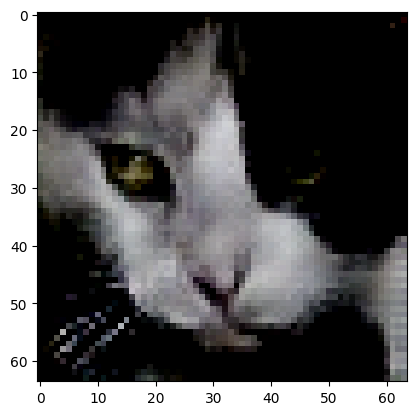

In [ ]:
img_path = '/content/extracted_folder/image_05290.png'
img = plt.imread(img_path)
plt.imshow(img)
plt.show()